In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
import sklearn.metrics as skmetrics
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VAR
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel
from prophet import Prophet
from statsforecast.core import StatsForecast
from statsforecast.models import AutoARIMA, AutoTheta, AutoETS
from sarimaCV import cross_validation

import warnings                               
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('Data/train.csv')
df.head(10)

,Datetime,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
0,2018-01-01 06:20:00+00:00,26.212347,28.696304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.00,3.976499,NaN,NaN,252.00,3.042750
1,2018-01-01 06:40:00+00:00,59.632658,29.052567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,11.091660,NaN,NaN,255.00,3.424814
2,2018-01-01 06:50:00+00:00,40.889650,28.984758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,264.75,4.234497,NaN,NaN,264.75,3.507172
3,2018-01-01 10:40:00+00:00,34.398111,30.282058,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,283.75,5.347792,NaN,NaN,283.75,3.442212
4,2018-01-01 12:00:00+00:00,29.797653,29.333519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,6.022326,NaN,NaN,274.00,3.031363
5,2018-01-01 12:10:00+00:00,103.805858,29.177815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,274.00,20.305917,NaN,NaN,274.00,3.781696
6,2018-01-01 12:20:00+00:00,89.304200,28.871782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.00,18.093654,NaN,NaN,265.00,3.727462
7,2018-01-01 12:30:00+00:00,136.319172,28.531796,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.00,27.029096,NaN,NaN,255.00,4.154484
8,2018-01-01 12:40:00+00:00,217.112015,28.344782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.00,43.690222,NaN,NaN,249.00,4.642134
9,2018-01-01 12:50:00+00:00,256.428119,28.244747,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.00,51.545672,NaN,NaN,241.00,4.841759


In [3]:
df.shape

(77202, 20)

In [3]:
df.isnull().sum()

Datetime                            0
ActivePower                         0
AmbientTemperatue                 896
BearingShaftTemperature         26684
Blade1PitchAngle                43282
Blade2PitchAngle                43365
Blade3PitchAngle                43365
GearboxBearingTemperature       26682
GearboxOilTemperature           26670
GeneratorRPM                    26674
GeneratorWinding1Temperature    26656
GeneratorWinding2Temperature    26649
HubTemperature                  26792
MainBoxTemperature              26704
NacellePosition                 20424
ReactivePower                      42
RotorRPM                        26680
TurbineStatus                   26466
WindDirection                   20424
WindSpeed                         308
dtype: int64

In [4]:
# drop the columns that have way to many missing values
df = df[['Datetime', 'ActivePower','ReactivePower', 'WindSpeed']]
corr_df = df[['ActivePower', 'ReactivePower', 'WindSpeed']]
corr_df.corr()

,ActivePower,ReactivePower,WindSpeed
ActivePower,1.000000,0.662881,0.937769
ReactivePower,0.662881,1.000000,0.616352
WindSpeed,0.937769,0.616352,1.000000


In [5]:
# Keep WindSpeed as an exog predictor for future use
train = df[['Datetime', 'ActivePower','WindSpeed']]
train = train.rename(columns={"Datetime": "ds", "ActivePower": "y"})
train['ds'] = pd.to_datetime(train['ds']).dt.tz_localize(None)
train_daily = train.groupby(pd.Grouper(key='ds', freq='D')).mean()
train_daily = train_daily.reset_index()

# since there's only 308 NaN windspeed values but 77202 total values, we drop the NaN values 
train_daily.dropna(inplace=True)

train_daily.head()

,ds,y,WindSpeed
0,2018-01-01,366.223561,5.263797
1,2018-01-02,462.550740,5.390719
2,2018-01-03,454.417752,5.295225
3,2018-01-04,369.952190,5.094994
4,2018-01-05,319.446595,4.915224


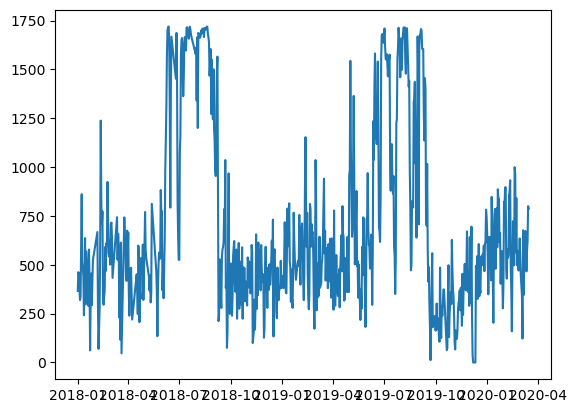

In [6]:
# This plot is hard to interpret
plt.plot(train_daily.set_index('ds').y)

In [7]:
# Try grouping them by month
train_month = train.groupby(pd.Grouper(key='ds', freq='M')).mean()
train_month = train_month.reset_index()
train_month.head()

,ds,y,WindSpeed
0,2018-01-31,445.629683,5.398479
1,2018-02-28,607.546661,5.887558
2,2018-03-31,588.055022,5.828535
3,2018-04-30,453.768575,5.230357
4,2018-05-31,550.100070,5.612135


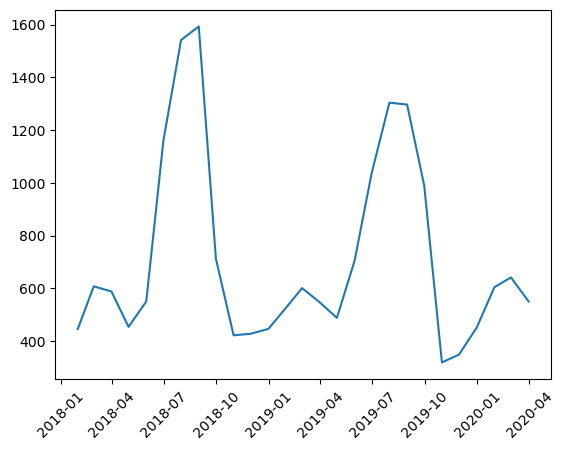

In [8]:
plt.plot(train_month.set_index('ds').y)
plt.xticks(rotation=45)
plt.show()

#### After grouping the ‘Datetime’ column into months, I think there's a seasonality of 365 based on the time series plot. 

In [9]:
history = train_daily[:-15][['ds', 'y']]
test = train_daily[-15:][['ds', 'y']]
print(len(history), len(test))

718 15


In [10]:
history.tail()

,ds,y
785,2020-02-25,516.014263
786,2020-02-26,470.661244
787,2020-02-27,541.003574
788,2020-02-28,634.866140
789,2020-02-29,532.321773


In [11]:
adf_result = adfuller(history.y, autolag='AIC')
dfoutput = pd.Series(adf_result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print(dfoutput[0:2])
if adf_result[1] <= 0.05:
    print('The time series is likely stationary (p-value <= 0.05)')
else:
    print('The time series is likely non-stationary (p-value > 0.05)')

Test Statistic   -3.190232
p-value           0.020557
dtype: float64
The time series is likely stationary (p-value <= 0.05)


#### ADF result is stationary, so there's no need to difference the data. Set d and D to 0.

<Figure size 3000x1000 with 0 Axes>

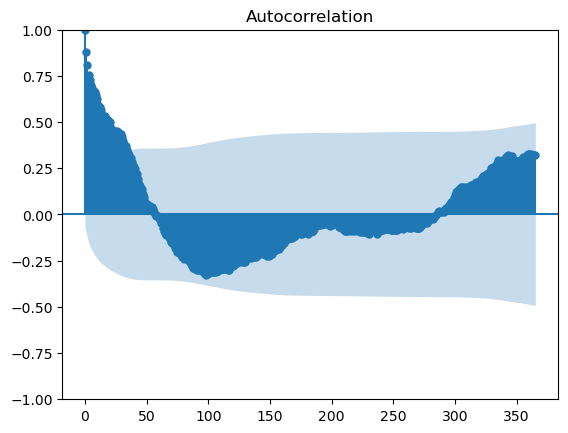

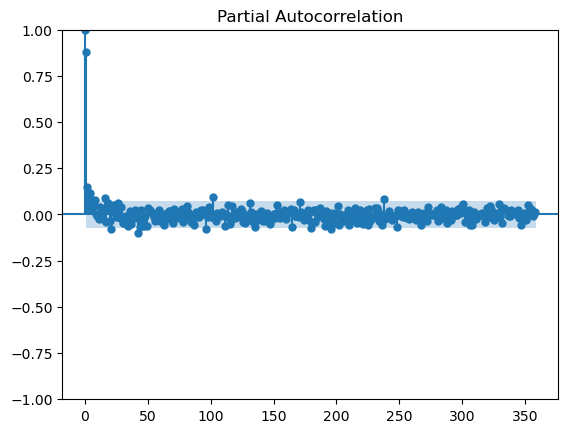

In [12]:
plt.figure(figsize=(30, 10))

plt.show()
plot_acf(history.y,lags=365)
plt.show()

# Don't have enough history data to do two lags=365 for PACF
plot_pacf(history.y,lags=358)
plt.show()

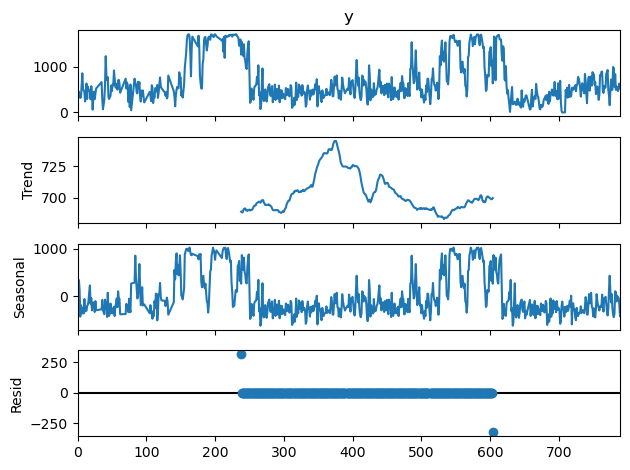

In [13]:
res = sm.tsa.seasonal_decompose(history.y,period=359,model="additive")
fig=res.plot()

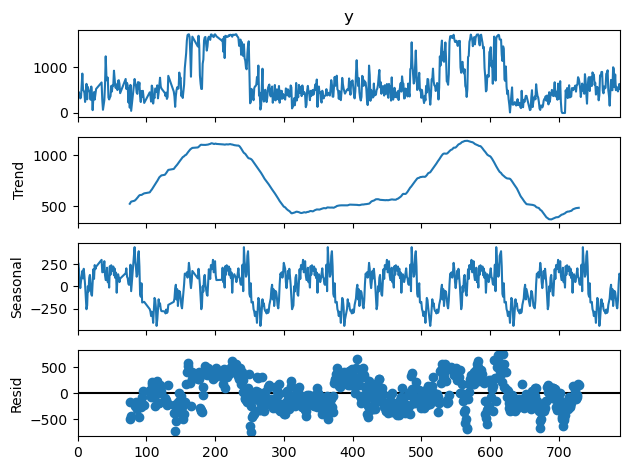

In [14]:
res = sm.tsa.seasonal_decompose(history.y,period=120,model="additive")
fig=res.plot()

### SARIMAX

In [15]:
exog_train = train_daily[train_daily['ds'] <= '2020-02-29'][['ds','y','WindSpeed']]
exog_train = exog_train.rename(columns={'WindSpeed': 'X'})
# exog_train = exog_train.set_index('ds')
exog_test = train_daily[train_daily['ds'] > '2020-02-29'][['ds','WindSpeed']]
exog_test = exog_test.rename(columns={'WindSpeed': 'X'})
# exog_test = exog_test.set_index('ds')
exog_train.tail()

,ds,y,X
785,2020-02-25,516.014263,5.584996
786,2020-02-26,470.661244,5.637419
787,2020-02-27,541.003574,5.638373
788,2020-02-28,634.866140,5.953927
789,2020-02-29,532.321773,5.646869


In [16]:
exog_train['unique_id'] = 'mean_daily_windpower'
exog_test['unique_id'] = 'mean_daily_windpower'

In [17]:
history_cp = history.copy()
history_cp['unique_id'] = 'mean_daily_windpower'
history_cp = history_cp.merge(exog_train, how = 'left', on = ['unique_id', 'ds', 'y'])
history
history_cp.tail()

,ds,y,unique_id,X
713,2020-02-25,516.014263,mean_daily_windpower,5.584996
714,2020-02-26,470.661244,mean_daily_windpower,5.637419
715,2020-02-27,541.003574,mean_daily_windpower,5.638373
716,2020-02-28,634.866140,mean_daily_windpower,5.953927
717,2020-02-29,532.321773,mean_daily_windpower,5.646869


In [18]:
exog_train.tail()

,ds,y,X,unique_id
785,2020-02-25,516.014263,5.584996,mean_daily_windpower
786,2020-02-26,470.661244,5.637419,mean_daily_windpower
787,2020-02-27,541.003574,5.638373,mean_daily_windpower
788,2020-02-28,634.866140,5.953927,mean_daily_windpower
789,2020-02-29,532.321773,5.646869,mean_daily_windpower


In [19]:
exog_test.tail()

,ds,X,unique_id
800,2020-03-11,5.385570,mean_daily_windpower
801,2020-03-12,5.693483,mean_daily_windpower
802,2020-03-13,5.765318,mean_daily_windpower
803,2020-03-14,6.217917,mean_daily_windpower
804,2020-03-15,6.458906,mean_daily_windpower


In [20]:
sf = StatsForecast(
    models=[AutoARIMA(season_length = 1)],
    freq='D' # frequency of your data
)
sf.fit(history_cp, exog_train)
forecast_df = sf.predict(15, exog_test, [90]) 
forecast_df.tail()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
mean_daily_windpower,2020-03-11,483.573273,314.171356,652.975220
mean_daily_windpower,2020-03-12,554.797668,385.112885,724.482422
mean_daily_windpower,2020-03-13,571.431274,401.464111,741.398376
mean_daily_windpower,2020-03-14,676.113220,505.864197,846.362183
mean_daily_windpower,2020-03-15,731.862244,561.331848,902.392639


In [21]:
rmse_test_arima = np.sqrt(skmetrics.mean_squared_error(test['y'], forecast_df['AutoARIMA']))
rmse_test_arima

48.458240320412216

#### ARIMA model test rmse is 48.458240320412216

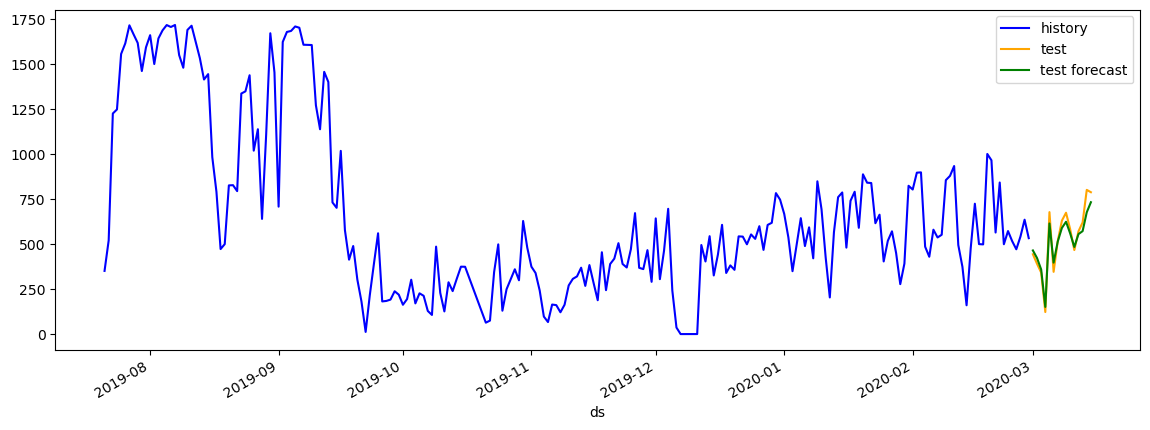

In [22]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history[500:].plot(kind='line', x='ds', y='y', color='blue', label='history', ax=ax)
test.plot(kind='line', x='ds', y='y',color='orange', label='test', ax=ax)
forecast_df.plot(kind='line', x='ds', y='AutoARIMA',color='green', label='test forecast', ax=ax)
plt.show()

### Might be overfitting? Fit a separate univariate model on WindSpeed

In [23]:
exog_history = train_daily[train_daily['ds'] <= '2020-02-29'][['ds','WindSpeed']]
exog_history = exog_history.rename(columns={'WindSpeed': 'y'})
exog_history['unique_id'] = 'mean_daily_windpower'
# exog_train = exog_train.set_index('ds')
exog_val = train_daily[train_daily['ds'] > '2020-02-29'][['ds','WindSpeed']]
exog_val = exog_val.rename(columns={'WindSpeed': 'y'})
exog_val['unique_id'] = 'mean_daily_windpower'
# exog_test = exog_test.set_index('ds')

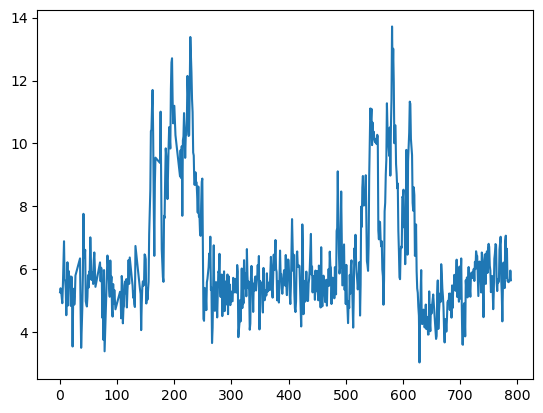

In [24]:
plt.plot(exog_history.y)

#### ARIMA on exog

In [25]:
season_length = 1 # Annual data 
horizon = len(exog_val) # number of predictions

sf = StatsForecast(
    df=exog_history,
    models=[AutoARIMA(season_length = season_length)],
    freq='D' # frequency of your data
)
sf.fit(exog_history)
Y_hat_df = sf.forecast(horizon, fitted=True)
Y_hat_df

,ds,AutoARIMA
unique_id,,
mean_daily_windpower,2020-03-01,5.658507
mean_daily_windpower,2020-03-02,5.632396
mean_daily_windpower,2020-03-03,5.651040
mean_daily_windpower,2020-03-04,5.637500
mean_daily_windpower,2020-03-05,5.623993
mean_daily_windpower,2020-03-06,5.610518
mean_daily_windpower,2020-03-07,5.597076
mean_daily_windpower,2020-03-08,5.583666
mean_daily_windpower,2020-03-09,5.570288


In [26]:
rmse_exog = np.sqrt(skmetrics.mean_squared_error(exog_val['y'], Y_hat_df.AutoARIMA))
rmse_exog

0.6404338009551599

#### Prophet on exog

In [27]:
m = Prophet(yearly_seasonality=True)
m.fit(exog_history)
#Fataframe with forecasting steps
future = m.make_future_dataframe(periods=15)
#Forecast
forecast_exog_prophet = m.predict(future)
forecast_exog_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

10:37:20 - cmdstanpy - INFO - Chain [1] start processing
10:37:21 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
728,2020-03-11,5.756691,4.411005,7.149032
729,2020-03-12,5.859566,4.461005,7.190606
730,2020-03-13,5.668106,4.293035,7.098054
731,2020-03-14,5.734131,4.392953,7.070531
732,2020-03-15,5.737255,4.417768,7.098593


In [28]:
rmse_exog = np.sqrt(skmetrics.mean_squared_error(exog_val['y'], forecast_exog_prophet.yhat[-15:]))
rmse_exog

0.6249165300129845

#### Theta on exog

In [29]:
models = [AutoTheta(season_length=season_length,
                     decomposition_type="additive",
                     model="STM")]

sf = StatsForecast(df=exog_history,
                   models=models,
                   freq='D', 
                   n_jobs=-1)

# prediction
y_hat_exog = sf.forecast(horizon, fitted=True)
y_hat_exog

,ds,AutoTheta
unique_id,,
mean_daily_windpower,2020-03-01,5.702386
mean_daily_windpower,2020-03-02,5.702168
mean_daily_windpower,2020-03-03,5.701949
mean_daily_windpower,2020-03-04,5.701731
mean_daily_windpower,2020-03-05,5.701512
mean_daily_windpower,2020-03-06,5.701294
mean_daily_windpower,2020-03-07,5.701076
mean_daily_windpower,2020-03-08,5.700857
mean_daily_windpower,2020-03-09,5.700639


In [30]:
rmse_exog = np.sqrt(skmetrics.mean_squared_error(exog_val['y'], y_hat_exog.AutoTheta))
rmse_exog

0.6266287348916398

#### ETS on exog

In [31]:
autoets = AutoETS(model=["A","Z","Z"],  alias="AutoETS", season_length=1)

autoets = autoets.fit(exog_history["y"].values)
autoets

y_hat_dict = autoets.predict(h=horizon)

forecast_ets_exog = pd.Series(pd.date_range("2020-03-01", freq="D", periods=15))
forecast_ets_exog = pd.DataFrame(forecast_ets_exog)
forecast_ets_exog.columns=["ds"]
forecast_ets_exog["y_hat"]=y_hat_dict.get("mean")
# forecast["unique_id"]="1"
forecast_ets_exog

,ds,y_hat
0,2020-03-01,5.702798
1,2020-03-02,5.702798
2,2020-03-03,5.702798
3,2020-03-04,5.702798
4,2020-03-05,5.702798
5,2020-03-06,5.702798
6,2020-03-07,5.702798
7,2020-03-08,5.702798
8,2020-03-09,5.702798
9,2020-03-10,5.702798


In [32]:
rmse_exog = np.sqrt(skmetrics.mean_squared_error(exog_val['y'], forecast_ets_exog.y_hat))
rmse_exog

0.6265833559600809

#### The best model on predicting the exogenous regression WindSpeed is the Prophet model, and the test RMSE is 0.6249165300129845

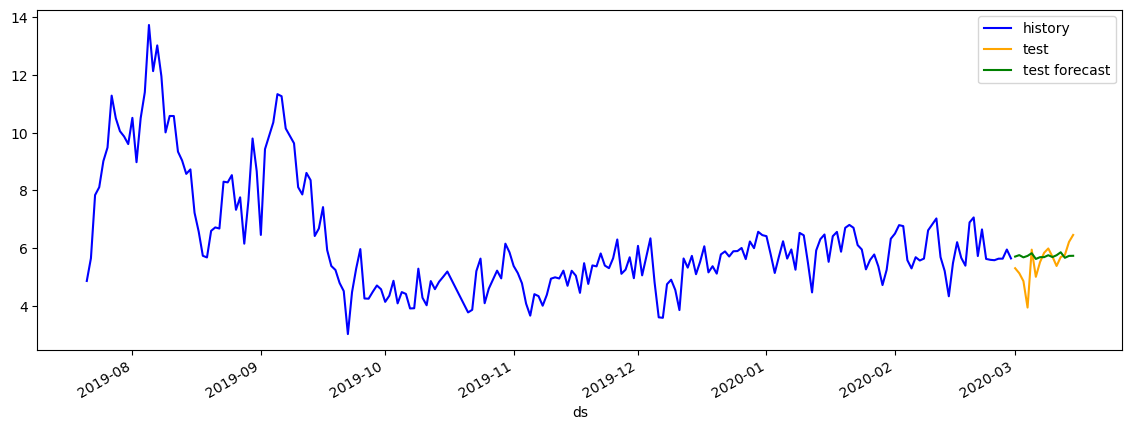

In [33]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
exog_history[500:].plot(kind='line', x='ds', y='y', color='blue', label='history', ax=ax)
exog_val.plot(kind='line', x='ds', y='y',color='orange', label='test', ax=ax)
forecast_exog_prophet[-15:].plot(kind='line', x='ds', y='yhat',color='green', label='test forecast', ax=ax)
plt.show()

#### Use the forecasted 'WindSpeed' during 03/01 - 03/15 as test set, and refit the model on history set

In [34]:
exog_train.tail()

,ds,y,X,unique_id
785,2020-02-25,516.014263,5.584996,mean_daily_windpower
786,2020-02-26,470.661244,5.637419,mean_daily_windpower
787,2020-02-27,541.003574,5.638373,mean_daily_windpower
788,2020-02-28,634.866140,5.953927,mean_daily_windpower
789,2020-02-29,532.321773,5.646869,mean_daily_windpower


In [35]:
history_cp = history.copy()
history_cp['unique_id'] = 'mean_daily_windpower'
history_cp = history_cp.merge(exog_train, how = 'left', on = ['unique_id', 'ds', 'y'])
history
history_cp.tail()

,ds,y,unique_id,X
713,2020-02-25,516.014263,mean_daily_windpower,5.584996
714,2020-02-26,470.661244,mean_daily_windpower,5.637419
715,2020-02-27,541.003574,mean_daily_windpower,5.638373
716,2020-02-28,634.866140,mean_daily_windpower,5.953927
717,2020-02-29,532.321773,mean_daily_windpower,5.646869


In [36]:
test_exog = forecast_exog_prophet[['ds', 'yhat']][-15:]
test_exog['unique_id'] = 'mean_daily_windpower'
test_exog = test_exog.rename(columns={'yhat': 'X'})
test_exog.tail()

,ds,X,unique_id
728,2020-03-11,5.756691,mean_daily_windpower
729,2020-03-12,5.859566,mean_daily_windpower
730,2020-03-13,5.668106,mean_daily_windpower
731,2020-03-14,5.734131,mean_daily_windpower
732,2020-03-15,5.737255,mean_daily_windpower


In [37]:
sf = StatsForecast(
    models=[AutoARIMA(season_length = 1)],
    freq='D' # frequency of your data
)
sf.fit(history_cp, exog_train)
forecast_df = sf.predict(15, test_exog, [90]) 
forecast_df.tail()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
mean_daily_windpower,2020-03-11,569.391968,399.990051,738.793945
mean_daily_windpower,2020-03-12,593.203125,423.518372,762.887939
mean_daily_windpower,2020-03-13,548.951660,378.984497,718.918762
mean_daily_windpower,2020-03-14,564.241699,393.992676,734.490662
mean_daily_windpower,2020-03-15,564.986084,394.455719,735.516479


In [38]:
rmse = np.sqrt(skmetrics.mean_squared_error(test['y'], forecast_df.AutoARIMA))
rmse

176.7180217315971

#### We should consider 176.7180217315971 as the final test RMSE for the SARIMAX model since we do not have the real data on 'WindSpeed' for 03/16 - 03/30. 

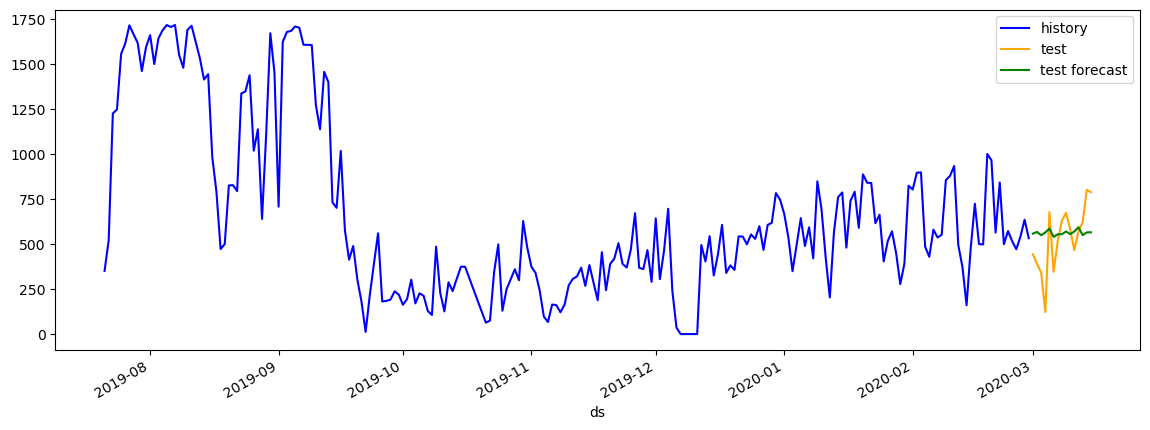

In [39]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history[500:].plot(kind='line', x='ds', y='y', color='blue', label='history', ax=ax)
test.plot(kind='line', x='ds', y='y',color='orange', label='test', ax=ax)
forecast_df.plot(kind='line', x='ds', y='AutoARIMA',color='green', label='test forecast', ax=ax)
plt.show()

### Theta Model

In [40]:
history_cp = history.copy()
history_cp['unique_id'] = 'mean_daily_windpower'

In [41]:
season_length = 1 # Annual data 
horizon = len(test) # number of predictions

models = [AutoTheta(season_length=season_length,
                     decomposition_type="additive",
                     model="STM")]

sf = StatsForecast(df=history_cp,
                   models=models,
                   freq='D', 
                   n_jobs=-1)

# prediction
y_hat = sf.forecast(horizon, fitted=True)
y_hat

,ds,AutoTheta
unique_id,,
mean_daily_windpower,2020-03-01,553.157471
mean_daily_windpower,2020-03-02,553.093323
mean_daily_windpower,2020-03-03,553.029175
mean_daily_windpower,2020-03-04,552.965027
mean_daily_windpower,2020-03-05,552.900879
mean_daily_windpower,2020-03-06,552.836731
mean_daily_windpower,2020-03-07,552.772583
mean_daily_windpower,2020-03-08,552.708435
mean_daily_windpower,2020-03-09,552.644287


In [42]:
rmse_test_theta = np.sqrt(skmetrics.mean_squared_error(test['y'], y_hat['AutoTheta']))
rmse_test_theta

178.72088983992094

In [43]:
# Manually fit a Theta model

model1_theta = ThetaModel(history.y, period=359, deseasonalize=True, method='additive')
model2_theta = ThetaModel(history.y, period=359, deseasonalize=True, method='auto')
model3_theta = ThetaModel(history.y, period=359, deseasonalize=False, method='additive')
model4_theta = ThetaModel(history.y, period=359, deseasonalize=False, method='auto')

In [44]:
res1 = model1_theta.fit()
res1_forecast = res1.forecast(len(test))
res2 = model2_theta.fit()
res2_forecast = res2.forecast(len(test))
res3 = model3_theta.fit()
res3_forecast = res3.forecast(len(test))
res4 = model4_theta.fit()
res4_forecast = res4.forecast(len(test))

In [45]:
rmse_test_theta1 = np.sqrt(skmetrics.mean_squared_error(test['y'], res1_forecast))
rmse_test_theta2 = np.sqrt(skmetrics.mean_squared_error(test['y'], res2_forecast))
rmse_test_theta3 = np.sqrt(skmetrics.mean_squared_error(test['y'], res3_forecast))
rmse_test_theta4 = np.sqrt(skmetrics.mean_squared_error(test['y'], res4_forecast))
print(rmse_test_theta1, rmse_test_theta2, rmse_test_theta3, rmse_test_theta4)

351.7910612162986 351.7910612162986 178.72187477228923 178.72187477228923


#### The best Theta model test RMSE is 178.72088983992094

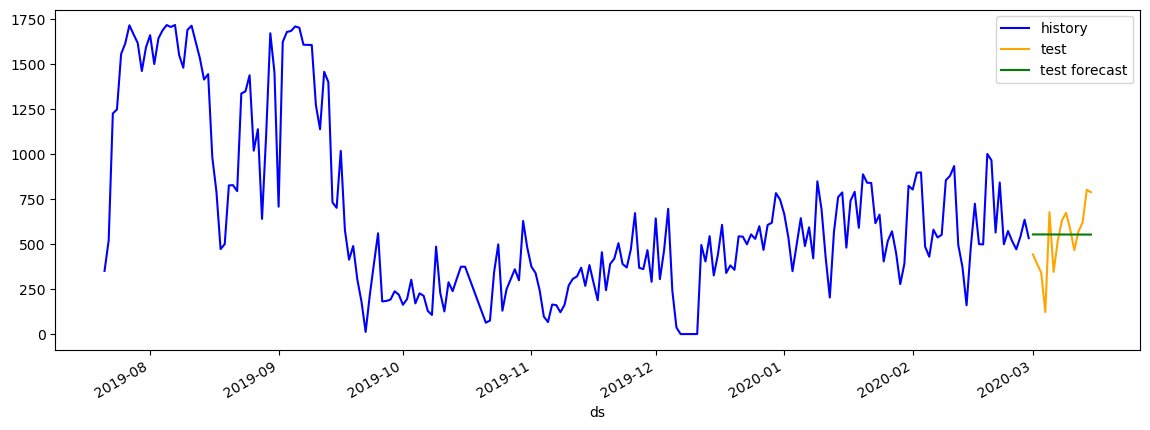

In [46]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history[500:].plot(kind='line', x='ds', y='y', color='blue', label='history', ax=ax)
test.plot(kind='line', x='ds', y='y',color='orange', label='test', ax=ax)
y_hat.plot(kind='line', x='ds', y='AutoTheta',color='green', label='test forecast', ax=ax)
plt.show()

### Exponential Smoonthing (ETS)

In [47]:
autoets = AutoETS(model=["A","Z","Z"],  alias="AutoETS", season_length=1)

autoets = autoets.fit(history_cp["y"].values)
autoets

y_hat_dict = autoets.predict(h=horizon)

forecast_ets = pd.Series(pd.date_range("2020-03-01", freq="D", periods=15))
forecast_ets = pd.DataFrame(forecast_ets)
forecast_ets.columns=["ds"]
forecast_ets["y_hat"]=y_hat_dict.get("mean")
# forecast["unique_id"]="1"
forecast_ets

,ds,y_hat
0,2020-03-01,553.247577
1,2020-03-02,553.247577
2,2020-03-03,553.247577
3,2020-03-04,553.247577
4,2020-03-05,553.247577
5,2020-03-06,553.247577
6,2020-03-07,553.247577
7,2020-03-08,553.247577
8,2020-03-09,553.247577
9,2020-03-10,553.247577


In [48]:
rmse_ets = np.sqrt(skmetrics.mean_squared_error(test['y'], forecast_ets.y_hat))
rmse_ets

178.5944563929041

#### ETS model test RMSE is 178.5944563929041

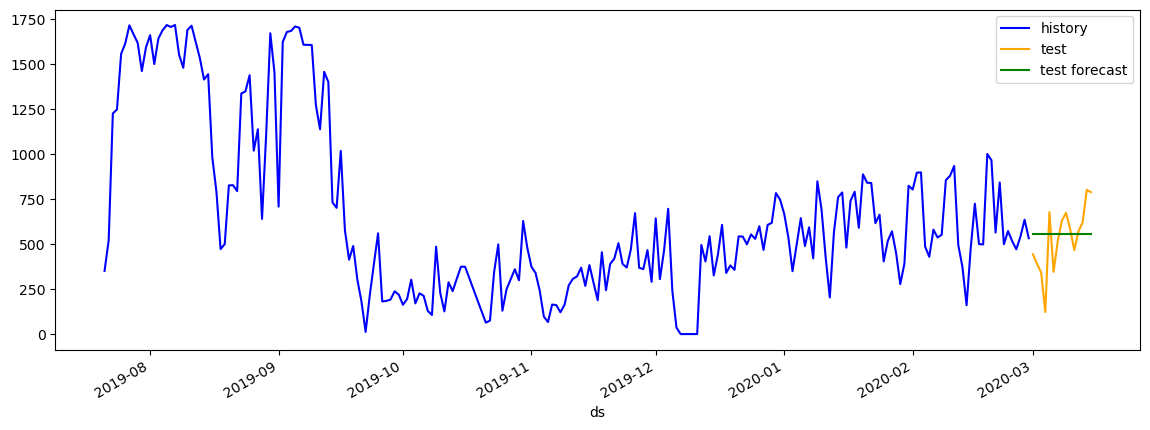

In [49]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
history[500:].plot(kind='line', x='ds', y='y', color='blue', label='history', ax=ax)
test.plot(kind='line', x='ds', y='y',color='orange', label='test', ax=ax)
forecast_ets.plot(kind='line', x='ds', y='y_hat',color='green', label='test forecast', ax=ax)
plt.show()

#### Finding: After adjusting the overfitting problems, all the three test RMSEs are very close to each other. The best one is still the SARIMAX model with the result of 176.72. Therefore, I decided to choose my SARIMAX model as the final model.

#### Get the forecasted values on WindSpeed

In [50]:
train_daily_cp = train_daily.copy()
train_daily_cp['unique_id'] = 'mean_daily_windpower'

exog_daily = train_daily_cp.rename(columns={'WindSpeed': 'X'})
exog_daily['unique_id'] = 'mean_daily_windpower'

exog_full = exog_daily[['ds', 'X']]
exog_full = exog_full.rename(columns={'X': 'y'})
exog_full.tail()

,ds,y
800,2020-03-11,5.385570
801,2020-03-12,5.693483
802,2020-03-13,5.765318
803,2020-03-14,6.217917
804,2020-03-15,6.458906


In [51]:
m = Prophet(yearly_seasonality=True)
m.fit(exog_full)
#Fataframe with forecasting steps
future = m.make_future_dataframe(periods=15)
#Forecast
forecast_exog = m.predict(future)
forecast_exog[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

10:37:31 - cmdstanpy - INFO - Chain [1] start processing
10:37:31 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
743,2020-03-26,5.706384,4.332019,7.191544
744,2020-03-27,5.472140,4.099061,6.870277
745,2020-03-28,5.506263,4.177285,6.945216
746,2020-03-29,5.471470,4.065536,6.759828
747,2020-03-30,5.484279,4.131847,6.815851


In [52]:
exog_forecasted = forecast_exog[['ds', 'yhat']][-15:]
exog_forecasted = exog_forecasted.rename(columns={'yhat': 'X'})
exog_forecasted['unique_id'] = 'mean_daily_windpower'
exog_forecasted

,ds,X,unique_id
733,2020-03-16,5.726188,mean_daily_windpower
734,2020-03-17,5.658879,mean_daily_windpower
735,2020-03-18,5.705626,mean_daily_windpower
736,2020-03-19,5.820922,mean_daily_windpower
737,2020-03-20,5.613295,mean_daily_windpower
738,2020-03-21,5.672503,mean_daily_windpower
739,2020-03-22,5.660526,mean_daily_windpower
740,2020-03-23,5.693182,mean_daily_windpower
741,2020-03-24,5.599161,mean_daily_windpower
742,2020-03-25,5.618486,mean_daily_windpower


In [53]:
train_daily_cp = train_daily_cp.merge(exog_daily, how = 'left', on = ['unique_id', 'ds', 'y']).drop(columns='WindSpeed')
train_daily_cp.tail()

,ds,y,unique_id,X
728,2020-03-11,466.289248,mean_daily_windpower,5.385570
729,2020-03-12,570.315539,mean_daily_windpower,5.693483
730,2020-03-13,619.637333,mean_daily_windpower,5.765318
731,2020-03-14,800.312824,mean_daily_windpower,6.217917
732,2020-03-15,787.305117,mean_daily_windpower,6.458906


In [54]:
exog_daily.tail()

,ds,y,X,unique_id
800,2020-03-11,466.289248,5.385570,mean_daily_windpower
801,2020-03-12,570.315539,5.693483,mean_daily_windpower
802,2020-03-13,619.637333,5.765318,mean_daily_windpower
803,2020-03-14,800.312824,6.217917,mean_daily_windpower
804,2020-03-15,787.305117,6.458906,mean_daily_windpower


In [55]:
sf = StatsForecast(
    models=[AutoARIMA(season_length = 1)],
    freq='D' # frequency of your data
)
sf.fit(train_daily_cp, exog_daily)
forecast_df = sf.predict(15, exog_forecasted, [90]) 
forecast_df.head()

,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90
unique_id,,,,
mean_daily_windpower,2020-03-16,591.438965,452.864441,730.013489
mean_daily_windpower,2020-03-17,562.810608,404.272278,721.348938
mean_daily_windpower,2020-03-18,575.730713,412.758728,738.702698
mean_daily_windpower,2020-03-19,602.254761,438.740143,765.769348
mean_daily_windpower,2020-03-20,554.604370,390.548950,718.659729


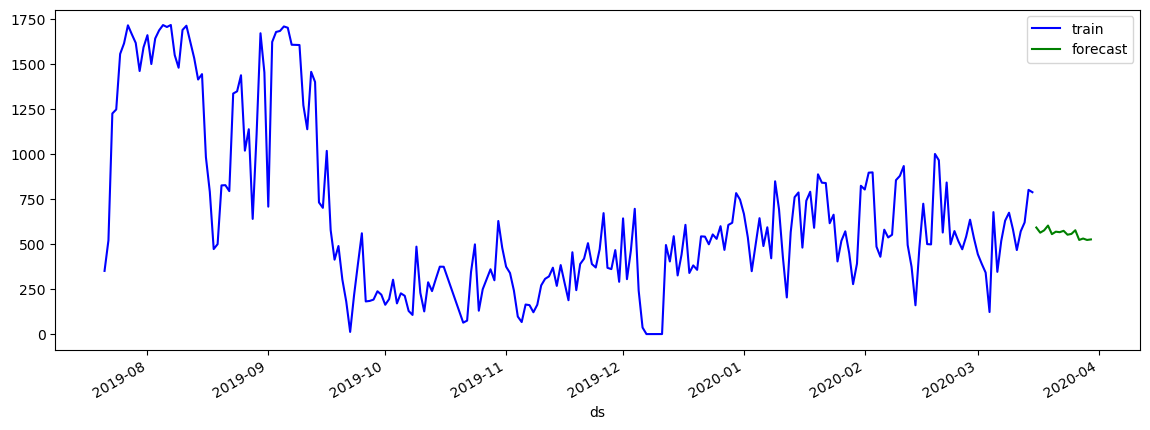

In [56]:
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(14,5))
train_daily[500:].plot(kind='line', x='ds', y='y', color='blue', label='train', ax=ax)
forecast_df.plot(kind='line', x='ds', y='AutoARIMA',color='green', label='forecast', ax=ax)
plt.show()

In [57]:
final_forecast = pd.Series(pd.date_range("2020-03-16", freq="D", periods=15))
final_forecast = pd.DataFrame(final_forecast)
final_forecast.columns=["Date"]
my_forecast = np.array(forecast_df['AutoARIMA'])
final_forecast["Forecasting"] = my_forecast
final_forecast

,Date,Forecasting
0,2020-03-16,591.438965
1,2020-03-17,562.810608
2,2020-03-18,575.730713
3,2020-03-19,602.254761
4,2020-03-20,554.604370
5,2020-03-21,568.245056
6,2020-03-22,565.534912
7,2020-03-23,573.076721
8,2020-03-24,551.521179
9,2020-03-25,556.000916
